Author: Marc Vivas Baiges
<br>
E-mail: vivasmarc001@gmail.com

# <h1> Image recognition - Age, gender and ethnicity classifier </h1>


## Introduction

I will be using a CSV of facial images that are labeled on the basis of age, gender, and ethnicity.


<br> You can download the dataset in the following link:
https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv

## Dependencies

In [100]:
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score


## <h1> Data loading </h1>




In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH_DATA_RAW = 'drive/MyDrive/Colab Notebooks/Datasets/age_gender.csv'

In [4]:
df_raw = pd.read_csv(PATH_DATA_RAW)


## Functions

In [139]:
def classification_evaluation(model, x_test, y_test):
  y_pred = model.predict(x_test)
  if len(y_pred[0]) > 1:
    y_pred = y_pred.argmax(axis=1)
    
  else:
    for i in range(len(y_pred)):
      y_pred[i][0] = round(y_pred[i][0])
      if y_pred[i][0] <0:
        y_pred[i][0] = 0
      elif y_pred[i][0] >1:
        y_pred[i][0] = 1
    
   
  cm = confusion_matrix(y_test, y_pred)  
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(
      cmap=plt.cm.Blues,
  )  

  print("")
  print(f' Accuracy: {accuracy_score(y_test, y_pred) * 100}%')
  

  plt.show()

In [163]:
def build_model(output_act_fn, output_num_neurons, loss, metrics):
  model = keras.Sequential([
        # Convolutional layers
        

        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(.15),

               
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'), 
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(.15),

       
      
        layers.Flatten(), 

        # Fully connected layers
       
        layers.Dense(output_num_neurons, activation=output_act_fn),
                                  
  ])
  model.compile(optimizer='adam',
              loss=loss,
              metrics=metrics
              )
  return model


## Data understanding

In [6]:
df_raw.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [8]:
df_raw.describe()

,age,ethnicity,gender
count,23705.000000,23705.000000,23705.000000
mean,33.300907,1.269226,0.477283
std,19.885708,1.345638,0.499494
min,1.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000
50%,29.000000,1.000000,0.000000
75%,45.000000,2.000000,1.000000
max,116.000000,4.000000,1.000000


### Columns study 

Brief definition of each column value and an expected value which can end up providing to the study.

1. age: Age of the person in the photo, it is one of the objectives attributes.
2. ethnicity: Ethnicity of the person in the photo, it is one of the objectives attributes.
> There is a total of 5 categories in the ethnicity column encoded as:
> <br> 0 --> White
> <br> 1 --> Black 
> <br> 2 --> Asian
> <br> 3 --> Indian
> <br> 4 --> Hispanic

3. gender: Gender of the person in the photo, it is one of the objectives attributes.
> There are 2 possible genders encoded as:
> <br> 0 --> Male
> <br> 1 --> Female

4. img_name: Image file name. This column won't be used because it doesn't provide useful information for the future models.
5. pixels: Array to String of the image pixels. This is the image, obviously is going to be used.

## Data preparation (1)

Drop img_name column

In [145]:
df = df_raw.drop(['img_name'], axis=1)


In [146]:
num_pixels = len(df['pixels'][0].split(" "))
img_height = int(np.sqrt(len(df['pixels'][0].split(" "))))
img_width = int(np.sqrt(len(df['pixels'][0].split(" "))))
print(f'num_pixels = {num_pixels}\nimg_height = {img_height}\nimg_width = {img_width}')

num_pixels = 2304
img_height = 48
img_width = 48


In [147]:
# String of pixels to array of pixels
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(), dtype='float'))

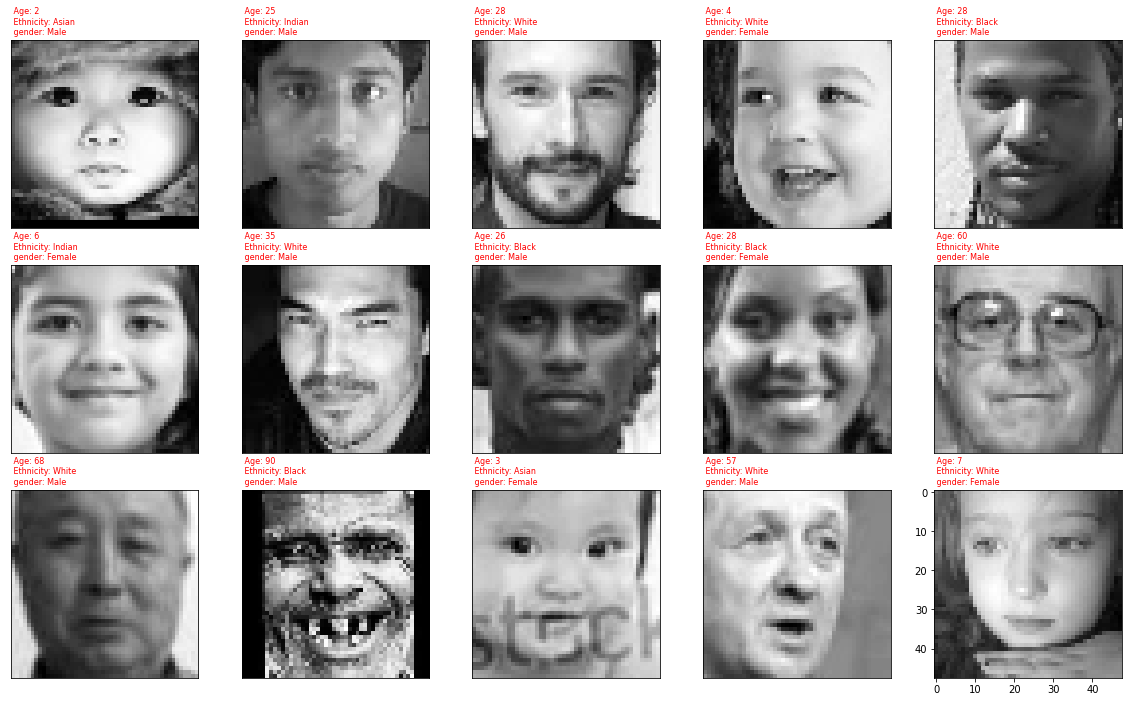

In [168]:
plt.figure(figsize=(20, 20))

for i in range(15):  
    index = np.random.randint(0, len(df))
    plt.xticks([])
    plt.yticks([])   
    plt.grid(False)
    plt.subplot(5, 5, i+1)
    plt.imshow(df['pixels'].iloc[index].reshape(48, 48),"gray")
    plt.title(' Age: {}\n Ethnicity: {}\n gender: {}'.format(df['age'].iloc[index], {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Hispanic"}[df['ethnicity'].iloc[index]], {0:"Male", 1:"Female"}[df['gender'].iloc[index]]),loc="left",color='red',fontsize = 8)

plt.show()


In [148]:
x = np.array(df['pixels'].tolist())
x = np.reshape(x, (-1, img_height, img_width, 1))
x = x/255 # Normalizing the images


In [149]:
"""
23705 48x48 images with only 1 channel (no color, just brightness intensity)
"""
x.shape 

(23705, 48, 48, 1)

## First model - Gender prediction

In [158]:
y = np.array(df['gender'])

x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y, test_size=0.2, random_state=222)

In [161]:
model_gender = build_model(output_act_fn='sigmoid', output_num_neurons=1, loss='binary_crossentropy', metrics=['accuracy'] ) 
model_gender.fit(x_train_gender, y_train_gender, epochs=40)

Epoch 1/40
593/593 [==============================] - 6s 9ms/step - loss: 0.4638 - accuracy: 0.7781
Epoch 2/40
593/593 [==============================] - 4s 6ms/step - loss: 0.3525 - accuracy: 0.8480
Epoch 3/40
593/593 [==============================] - 4s 6ms/step - loss: 0.3222 - accuracy: 0.8627
Epoch 4/40
593/593 [==============================] - 4s 6ms/step - loss: 0.3010 - accuracy: 0.8713
Epoch 5/40
593/593 [==============================] - 4s 6ms/step - loss: 0.2846 - accuracy: 0.8804
Epoch 6/40
593/593 [==============================] - 4s 6ms/step - loss: 0.2726 - accuracy: 0.8832
Epoch 7/40
593/593 [==============================] - 4s 6ms/step - loss: 0.2598 - accuracy: 0.8918
Epoch 8/40
593/593 [==============================] - 4s 6ms/step - loss: 0.2504 - accuracy: 0.8942
Epoch 9/40
593/593 [==============================] - 4s 6ms/step - loss: 0.2374 - accuracy: 0.9015
Epoch 10/40
593/593 [==============================] - 4s 6ms/step - loss: 0.2360 - accuracy: 0.9027


 Accuracy: 90.12866483864164%


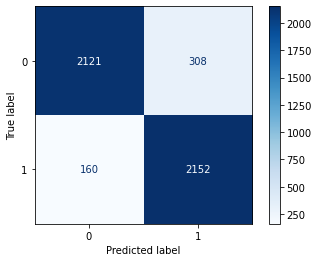

In [162]:
classification_evaluation(model_gender, x_test_gender, y_test_gender)

## Second model - Ethnicity prediction

In [105]:
y_eth = np.array(df['ethnicity'])

x_train_eth, x_test_eth, y_train_eth, y_test_eth = train_test_split(x, y_eth, test_size=0.2, random_state=222)

In [143]:
model_eth = build_model(output_act_fn='softmax', output_num_neurons=5, loss='sparse_categorical_crossentropy', metrics=['accuracy'] ) 
model_eth.fit(x_train_eth, y_train_eth, epochs=26)

Epoch 1/26
593/593 [==============================] - 4s 6ms/step - loss: 1.0158 - accuracy: 0.6242
Epoch 2/26
593/593 [==============================] - 3s 6ms/step - loss: 0.7846 - accuracy: 0.7259
Epoch 3/26
593/593 [==============================] - 3s 6ms/step - loss: 0.7141 - accuracy: 0.7549
Epoch 4/26
593/593 [==============================] - 3s 6ms/step - loss: 0.6731 - accuracy: 0.7667
Epoch 5/26
593/593 [==============================] - 3s 6ms/step - loss: 0.6362 - accuracy: 0.7818
Epoch 6/26
593/593 [==============================] - 3s 6ms/step - loss: 0.6037 - accuracy: 0.7902
Epoch 7/26
593/593 [==============================] - 3s 6ms/step - loss: 0.5782 - accuracy: 0.7991
Epoch 8/26
593/593 [==============================] - 3s 6ms/step - loss: 0.5547 - accuracy: 0.8082
Epoch 9/26
593/593 [==============================] - 4s 6ms/step - loss: 0.5281 - accuracy: 0.8163
Epoch 10/26
593/593 [==============================] - 3s 6ms/step - loss: 0.5071 - accuracy: 0.8228


 Accuracy: 78.9706812908669%


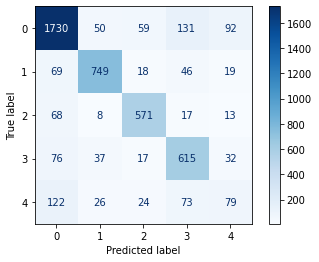

In [144]:
classification_evaluation(model_eth, x_test_eth, y_test_eth)

## Third model - Age prediction

In [151]:
y_age = np.array(df['age'])

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, random_state=222)

In [154]:
model_age = build_model(output_act_fn=None, output_num_neurons=1, loss='mae', metrics=['mae'] ) 
model_age.fit(x_train_age, y_train_age, epochs=26)

Epoch 1/26
593/593 [==============================] - 5s 7ms/step - loss: 14.8326 - mae: 14.8326
Epoch 2/26
593/593 [==============================] - 4s 6ms/step - loss: 12.2236 - mae: 12.2236
Epoch 3/26
593/593 [==============================] - 4s 6ms/step - loss: 11.5578 - mae: 11.5578
Epoch 4/26
593/593 [==============================] - 4s 6ms/step - loss: 11.0317 - mae: 11.0317
Epoch 5/26
593/593 [==============================] - 4s 6ms/step - loss: 10.7124 - mae: 10.7124
Epoch 6/26
593/593 [==============================] - 4s 6ms/step - loss: 10.3191 - mae: 10.3191
Epoch 7/26
593/593 [==============================] - 4s 7ms/step - loss: 9.9420 - mae: 9.9420
Epoch 8/26
593/593 [==============================] - 4s 6ms/step - loss: 9.6264 - mae: 9.6264
Epoch 9/26
593/593 [==============================] - 4s 6ms/step - loss: 9.3303 - mae: 9.3303
Epoch 10/26
593/593 [==============================] - 4s 6ms/step - loss: 9.1162 - mae: 9.1162
Epoch 11/26
593/593 [================

In [157]:
model_age.evaluate(x_test_age, y_test_age)

149/149 [==============================] - 1s 5ms/step - loss: 7.6992 - mae: 7.6992


[7.699179172515869, 7.699179172515869]